# Laboratorio 3

In [1]:
#---------------------------------------------------------------------------------
# Project    : Laboratorio N°3
# Authors    : Mugni Juan Mauricio
# Affiliation: UNC
# E-mail     : mauricio.mugni@mi.unc.edu.ar
#---------------------------------------------------------------------------------

Instalación del programa para interactuar con dispositivos diseñados por Analog Device con un alto grado de abstracción, mediante el lenguaje Python:

In [2]:
#! pip install pyadi-iio #Una vez instalado descomentar #El signo admiración es parte de la sentencia!

Librería de Python para hacer uso del software. Me permite utilizar objetos para reconfigurar el hardware.

In [3]:
import adi

Se instalan las siguientes librerías:

In [4]:
#! pip install matplotlib               #El signo admiración es parte de la sentencia!
#! pip install scikit-dsp-comm          #El signo admiración es parte de la sentencia!
#! pip install scikit-commpy            #El signo admiración es parte de la sentencia!

Agregamos librerias

In [5]:
#------------------------------- Librerias ------------------------------- 
import numpy as np
import matplotlib.pyplot as plt

Se crea el objeto SDR y se lo víncula con el dispositivo que se encuentra en la dirección proporcionada por la variable URI

In [6]:
Uri = "ip:192.168.1.32" # "ip:192.168.1.35" "ip:192.168.1.34" "ip:192.168.1.33" "ip:192.168.1.32"
sdr = adi.Pluto(Uri)  

Definimos el número de muestras:

In [7]:
nSamples     = 2**15                                   #Número de muestras -> tamaño del buffer
samplingRate = 2.0e6                                   #Promedio de muestas -> muestras por segundo

Generamos una señal (hipótesis) binaria compleja que se puede modificar, a través de la variable `ref`, y definimos la probabilidad de ocurrencia de los valores binarios: 

In [8]:
ref = 0.5                                                        # Probabilidad de ocurrencia

z = np.random.uniform(size=nSamples)                             # Generador uniforme de números aleatorios
x = [1 if z[i]>ref else 0 for i in range(len(z))]                # Completo el vector binario de acuerdo a la probabilidad de ocurrencia 

txSignal = (2*np.repeat(x, 2**4)-1)+1j*(2*np.repeat(x, 2**4)-1)  # Señal binaria compleja

## Gráfica temporal de la señal

En este punto se busca graficar la parte real e imaginaria de la señal que se va a transmitir, para ello se define la siguiente función:

In [13]:
def plotSignal(signal):
#------------------------------- Transmitted I component ------------------------------- 
# Plot time domain
    plt.figure(figsize=(20,8), dpi= 80, facecolor='w', edgecolor='k')
    plt.subplot(2,1,1)
    plt.plot(np.real(signal))
    plt.xlabel('n')
    plt.ylabel('Amplitud')
    plt.title('Componente en fase de la señal')
    plt.grid()
#------------------------------- Transmitted Q component -------------------------------
# Plot time domain
    plt.subplot(2,1,2)
    plt.plot(np.imag(signal))
    plt.xlabel('n')
    plt.ylabel('Amplitud')
    plt.title('Componente en cuadratura de la señal')
    plt.grid()
    plt.show()

Graficamos la señal:

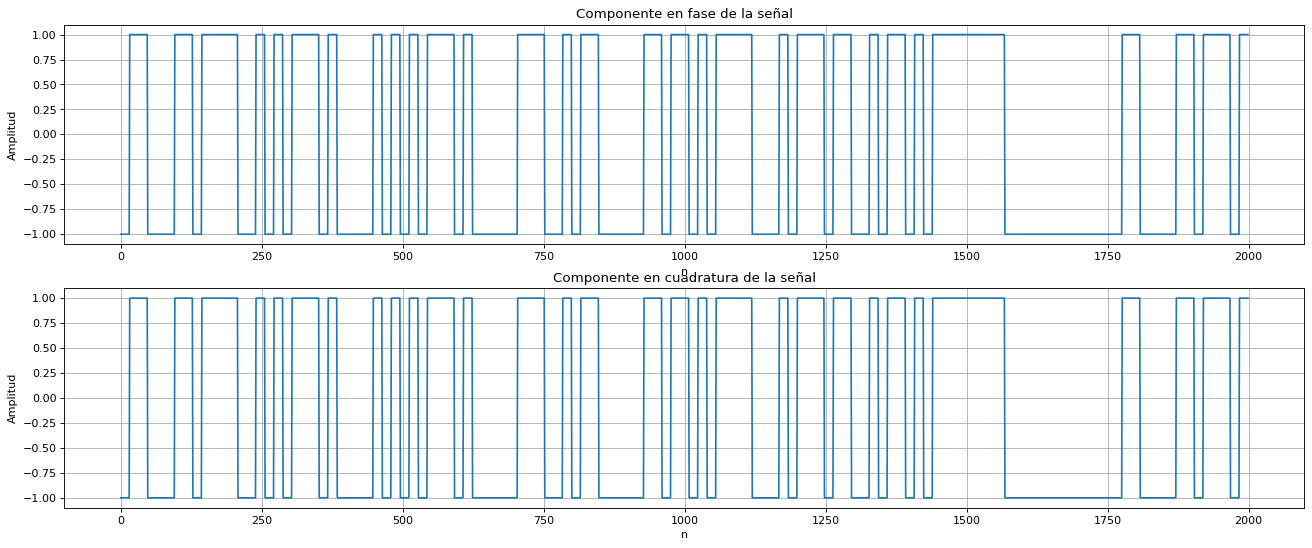

In [10]:
plotSignal(txSignal[0:2000])

## Grafica en frecuencia de la señal

Se pretende graficar el espectro de la densidad de potencia, definimos la siguiete función:

In [14]:
def plotSpect(signal,samplingRate):
    plt.subplots(figsize=(15, 3))
    plt.grid()
    plt.title("Power Spectral Density")
    plt.psd(signal, len(signal), samplingRate, color='C1')
    plt.show()

Graficamos la densidad espectral:

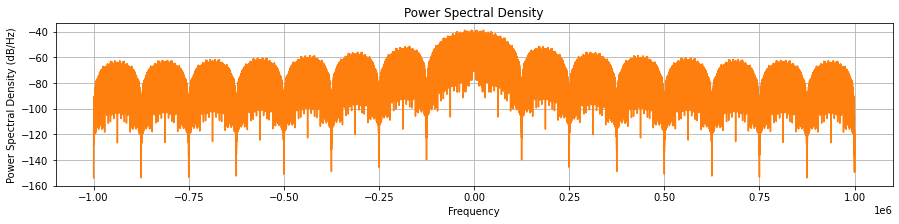

In [12]:
plotSpect(txSignal,samplingRate)

## Histograma de la señal

Graficamos el histograma de la señal para ver las componenentes de la señal.

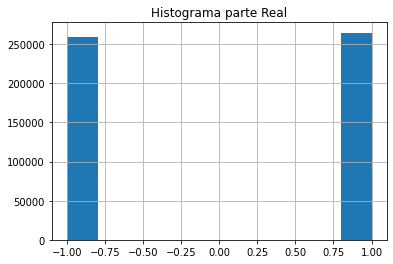

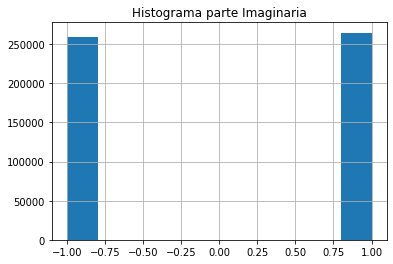

In [13]:
plt.hist(txSignal.real)
plt.grid()
plt.title("Histograma parte Real")
plt.show()

plt.hist(txSignal.imag)
plt.title("Histograma parte Imaginaria")
plt.grid()
plt.show()

## Observación de la grafica

Se esta generando una señal a partir de un vector que toma valores aleatorios entre $1$ y $0$. Se define la probabilidad para generar los valores, por una distribución uniforme y una referencia. La señal a transmitir toma valores entre $1$ y $-1$. 
Lo que se puede ver en las gráficas es lo siguiente:
-  Analizando el dominio del tiempo, notamos que tanto la señal real como imaginaria forman una señal de amplitud $1$ y $-1$. Toma estos valores con la misma probabilidad,  y se verifica con el histograma.
- Analizando el dominio de la frecuencia, se ve que tiene una densidad espectral alta, ya que abarca todas las componentes de frecuencia. Desde las más bajas hasta $1MHz$ que es la frecuencia de muestreo, extendiendose hasta el infinito. Tambien se puede ver la ausencia de ciertas frecuencias en algunos puntos, dando la forma de la curvatura.
- Se ven dos columnas centradas en $1$ y $-1$ respectivamente con la misma frecuencia. Representando la equiprobabilidad.

## Transmisión y Recepción 

### Configuración SDR

Limpiamos el buffer primero para evitar datos anteriores.

In [9]:
sdr.tx_destroy_buffer()

Configuramos el SDR de la siguiente manera:

In [10]:
Loopback         = 0             # 0=Disabled, 1=Digital loopback, 2=Retransmiter                                 

# Tx
TxLOFreq         = 954e6         # Carrier frequency of TX path [Hz]
TxAtten          = -77           # Attenuation applied to TX path, valid range is -89 to 0 dB [dB]
TxRfBw           = 2.0e6         # Bandwidth of front-end analog filter of TX path [Hz]
tx_cyclic_buffer = True

#Rx
RxLOFreq         = TxLOFreq      # Carrier frequency of RX path [Hz]
GainControlModes = "manual"      # Receive path AGC Options: slow_attack, fast_attack, manual
RxHardwareGain   = 70            # Gain applied to RX path. Only applicable when gain_control_mode is set to 'manual'    
RxRfBw           = TxRfBw        # Bandwidth of front-end analog filter of RX path [Hz] 
RxBufferSize     = len(txSignal) # Rx Buffer size. Maximun value 2**28 [Samples]

sdr.loopback        = Loopback      # Lazo de retorno

sdr.sample_rate = samplingRate

sdr.tx_rf_bandwidth = int(TxRfBw)   # Bandwidth of front-end analog filter of TX path [Hz]
sdr.rx_rf_bandwidth = int(RxRfBw)   # Bandwidth of front-end analog filter of RX path [Hz] 

sdr.tx_hardwaregain_chan0 = TxAtten
sdr.rx_hardwaregain_chan0 = RxHardwareGain
sdr.gain_control_mode_chan0 = GainControlModes

sdr.tx_lo = int(TxLOFreq) # Carrier frequency of TX path [Hz]
sdr.rx_lo = int(RxLOFreq) # Carrier frequency of RX path [Hz]

sdr.rx_buffer_size   = RxBufferSize
sdr.tx_cyclic_buffer = tx_cyclic_buffer
#sdr._ctrl.context.set_timeout(0)    # <- disable timeout if you want to use large buffer size

### Transmisión

Se transmite:

In [59]:
#------------------------------- Transmitter ------------------------------- 
sdr.tx(txSignal*(2**15-1)) # The PlutoSDR expects samples to be between -2^15-1 and +2^15-1, not -1 and +1 like some SDRs

### Recepción

Para evitar capturar la señal en algún estado transitorio inicial y para eliminar del buffer del receptor muestras de señales tomadas con anterioridad, ejecuta lo siguiente antes de recibir la señal:

In [60]:
#Clear RX Buffer
for i in range(10):
    raw_data = sdr.rx()
    
#------------------------------- Receiver ------------------------------- 
rxSignal = sdr.rx()

Normailizamos la señal recibida para que tenga potencia unitaria.

In [61]:
desviacionReal = rxSignal.real.std()
print("Desviacion Real: ", desviacionReal)

desviacionImag = rxSignal.imag.std()
print("Desviacion Imaginaria: ",desviacionImag)

rxSignalRealN = rxSignal.real/desviacionReal
rxSignalImagN = rxSignal.imag/desviacionImag

Desviacion Real:  137.98492980927205
Desviacion Imaginaria:  100.50032974889993


### Grafica temporal de la señal recibida

Se gafica la señal recibida en el dominio del tiempo, vemos su parte real e imaginaria:

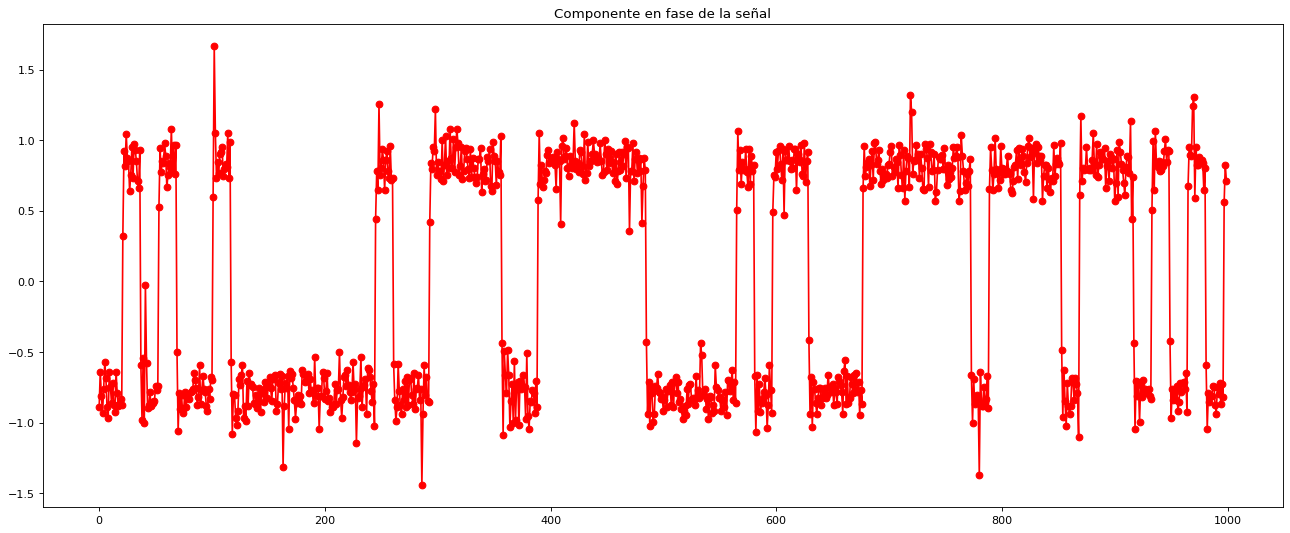

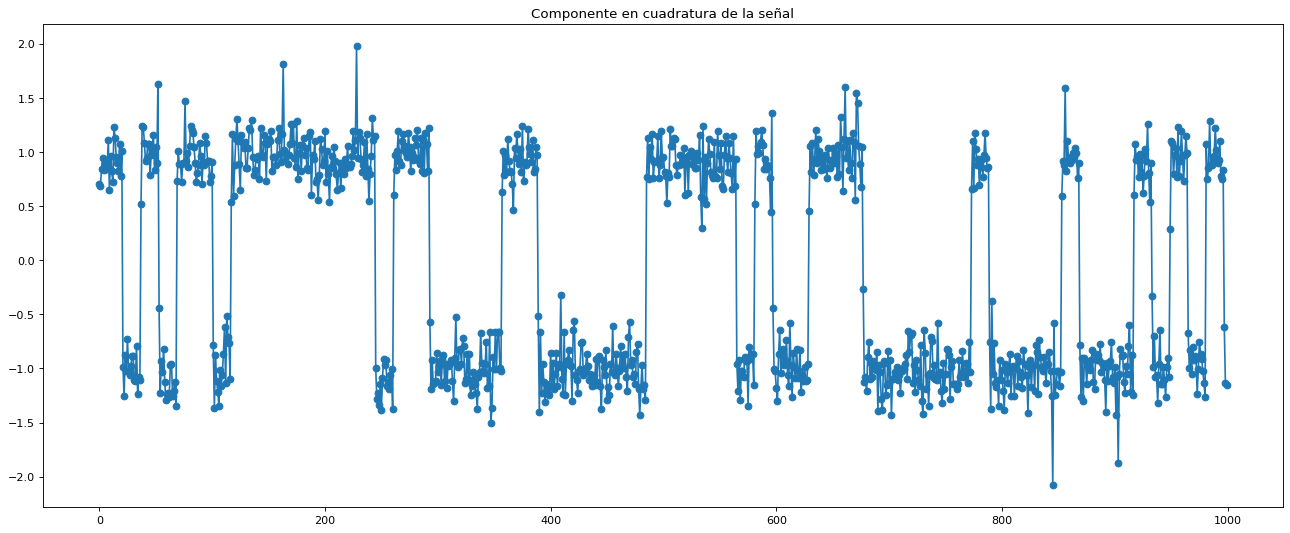

In [62]:
plt.figure(figsize=(20,8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(rxSignalRealN[2000:3000],marker="o", color='r')
plt.title("Componente en fase de la señal")
plt.show()

plt.figure(figsize=(20,8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(rxSignalImagN[2000:3000],marker="o")
plt.title("Componente en cuadratura de la señal")
plt.show()

### Grafica en frecuencia de la señal 

Se grafica la densidad espectral de potencia de la señal recibida

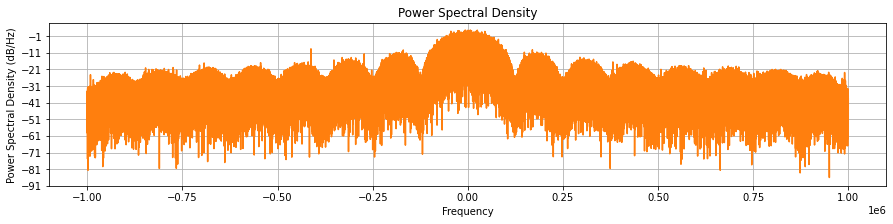

In [63]:
plotSpect(rxSignal,samplingRate)

### Histograma de la señal recibida

Realizamos el histograma de la señal normalizada, tanto de la parte real como imaginaria:

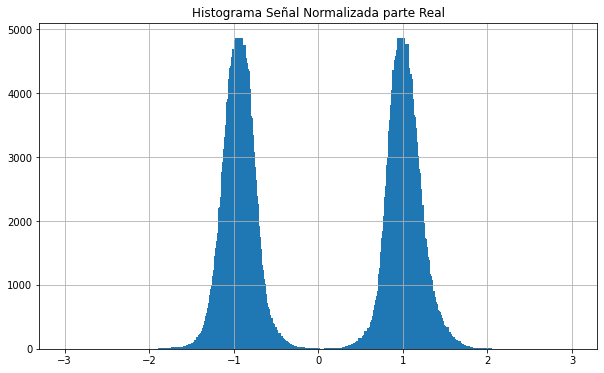

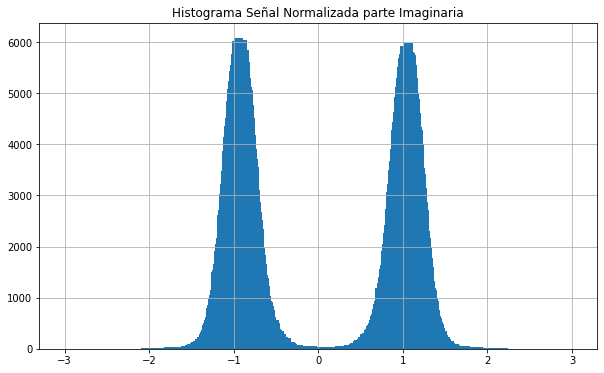

In [64]:
plt.figure(figsize=(10, 6))
plt.hist(rxSignalRealN, bins=10000, range=(-3, 3), width=0.1)
plt.title("Histograma Señal Normalizada parte Real")
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(rxSignalImagN, bins=10000, range=(-3, 3), width=0.1)
plt.title("Histograma Señal Normalizada parte Imaginaria")
plt.grid()
plt.show()

### Observación de la grafica

A partir de las gráficas podemos deducir lo siguiente:
- De la grafica con respecto al tiempo, en la parte real estamos viendo una onda cuadrada, de igual manera con la parte imaginaria. Donde su periodo es aleatorio y toma los valores de $\{ 1, -1 \}$. Para obtener esta gráfica fue necesario modificar la atenuación y la ganancia del SDR, ya que no se llegaba a observar señales cuadradas. Se puede apreciar que estamos recibiendo la misma señal creada anteriormente.
- De la gráfica de densidad espectral, podemos ver la potencia, sus infinitas componentes armónicas, y como en algunos puntos presenta ausencia de ciertas frecuencias dando como resultado cierta curvatura. Se puede ver que el ancho de banda es de $2MHz$, el cual es definido por la frecuencia de muestreo.
- Y del histograma de la señal normalizada, se puede ver como la señal se encuentra centrada en $-1$ y $1$ que son los valores que se han enviado. Se aprecia lo mismo tanto para la parte real como para la parte imaginaria.

## Aumento de la potencia transmitida

Limpiamos el buffer del transmisor, para que transmita con otra configuración: 

In [93]:
sdr.tx_destroy_buffer()
sdr.tx_cyclic_buffer = tx_cyclic_buffer

Configuramos el SDR de la siguiente manera:

In [94]:
TxAtten          = -70              # Attenuation applied to TX path, valid range is -89 to 0 dB [dB]
sdr.tx_hardwaregain_chan0 = TxAtten  

### Transmisión

Transmitimos

In [95]:
#------------------------ Transmitter ------------------------------- 
sdr.tx(txSignal*(2**15-1)) # The PlutoSDR expects samples to be between -2^15-1 and +2^15-1, not -1 and +1 like some SDRs

### Recepción
Recibimos la señal nuevamente:

In [101]:
#Clear RX Buffer
for i in range(15):
    raw_data = sdr.rx()
    
#------------------------------- Receiver ------------------------------- 
rxSignal = sdr.rx()

### Normalización
Normailizamos la señal recibida para que tenga potencia unitaria.

In [102]:
desviacionReal = rxSignal.real.std()
print("Desviacion Real: ", desviacionReal)

desviacionImag = rxSignal.imag.std()
print("Desviacion Imaginaria: ",desviacionImag)

rxSignalRealN = rxSignal.real/desviacionReal
rxSignalImagN = rxSignal.imag/desviacionImag

Desviacion Real:  302.3964667005399
Desviacion Imaginaria:  219.45919689415928


### Grafica temporal de la señal recibida
Se gafica la señal recibida en el dominio del tiempo, vemos su parte real e imaginaria:

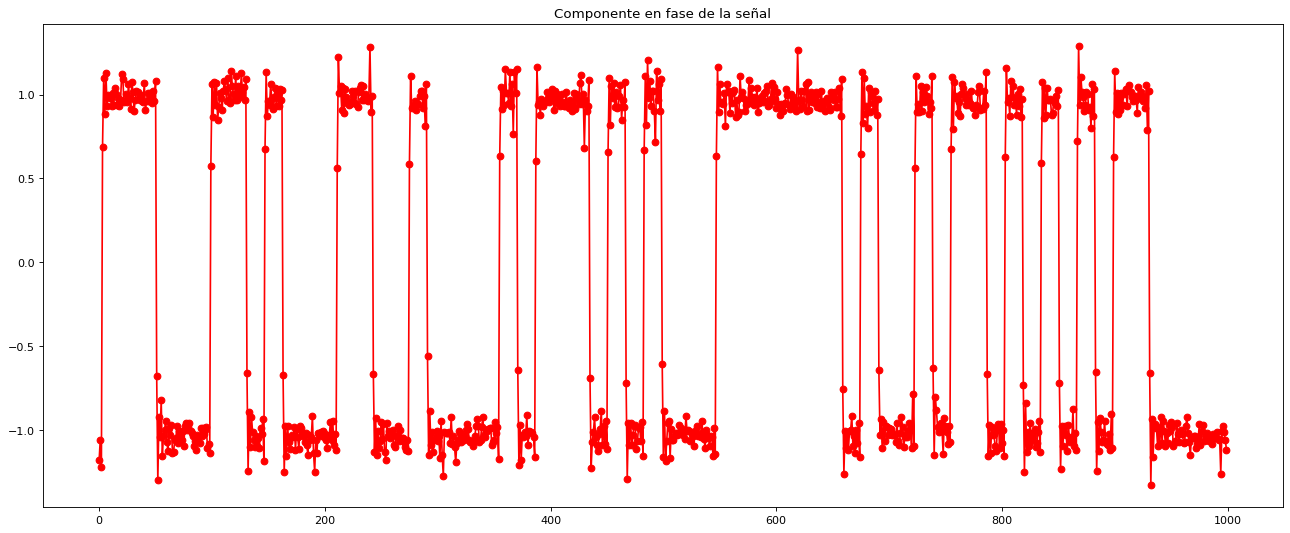

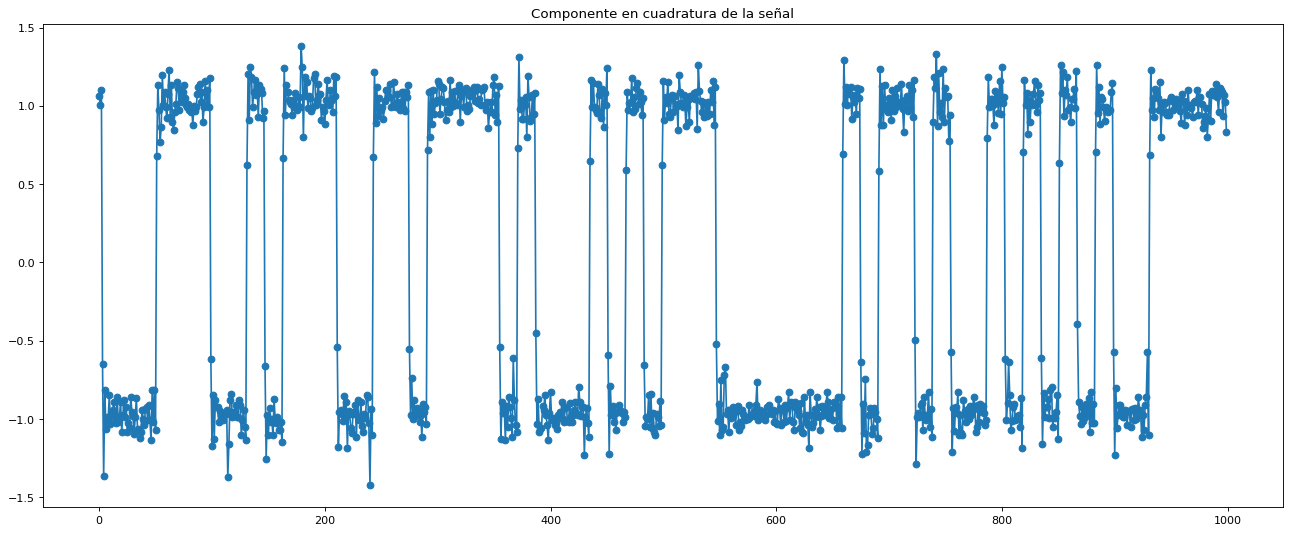

In [98]:
plt.figure(figsize=(20,8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(rxSignalRealN[2000:3000],marker="o", color='r')
plt.title("Componente en fase de la señal")
plt.show()

plt.figure(figsize=(20,8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(rxSignalImagN[2000:3000],marker="o")
plt.title("Componente en cuadratura de la señal")
plt.show()

### Grafica en frecuencia de la señal recibida
Se grafica la densidad espectral de potencia de la señal recibida

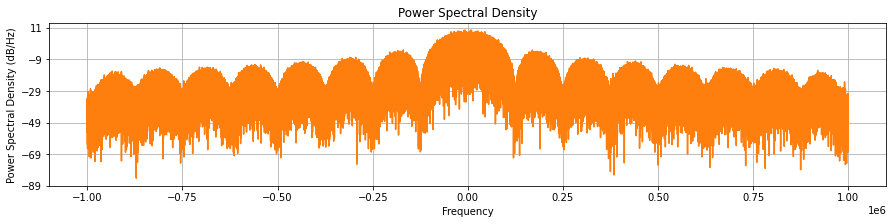

In [99]:
plotSpect(rxSignal,samplingRate)

### Histograma de la señal recibida
Realizamos el histograma de la señal normalizada, tanto de la parte real como imaginaria:

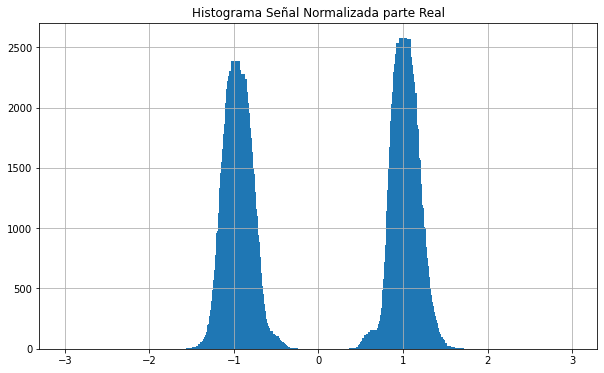

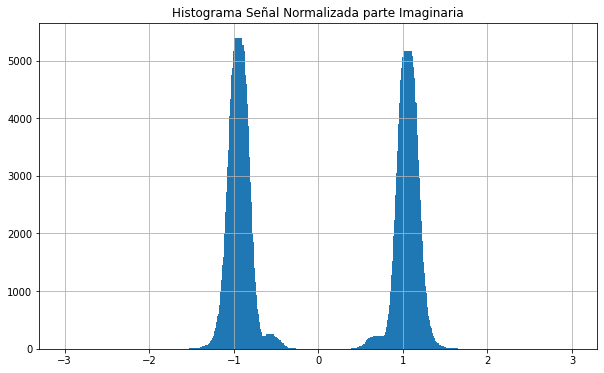

In [103]:
plt.figure(figsize=(10, 6))
plt.hist(rxSignalRealN, bins=10000, range=(-3, 3), width=0.1)
plt.title("Histograma Señal Normalizada parte Real")
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(rxSignalImagN, bins=10000, range=(-3, 3), width=0.1)
plt.title("Histograma Señal Normalizada parte Imaginaria")
plt.grid()
plt.show()

### Coclusiones al cambiar la potencia

A partir de las gráficas podemos deducir lo siguiente:
- De la grafica con respecto al tiempo, se continua viendo una onda cuadrada, de igual manera con la parte imaginaria. Donde su periodo es aleatorio y toma los valores de $\{ 1, -1 \}$
- De la grafica de densidad espectral, podemos ver una señal de mayor potencia, cada arco esta más definido (cada frecuencia tiene más potencia) y su gran ancho de banda.   
- Y del histograma podemos apreciar, como se encuentra centrado en $-1$ y $1$ de manera más definida. Entonces, podemos distinguir con mucha seguridad y con muy poca probabilidad de error cuando es $1$ y cuando es $-1$. La desviación estandar de cada hipótesis ha disminuido.

## Cambio en el nivel de decisión

Para esto se cambio el `threshold`a $0.3$

Generamos una nueva señal (hipótesis) binaria compleja que se puede modificar, a través de la variable `ref`, y definimos la probabilidad de ocurrencia de los valores binarios: 

In [115]:
ref = 0.3                                                        # Probabilidad de ocurrencia

z = np.random.uniform(size=nSamples)                             # Generador uniforme de números aleatorios
x = [1 if z[i]>ref else 0 for i in range(len(z))]                # Completo el vector binario de acuerdo a la probabilidad de ocurrencia 

txSignal = (2*np.repeat(x, 2**4)-1)+1j*(2*np.repeat(x, 2**4)-1)  # Señal binaria compleja

### Gráfica temporal de la señal

En este punto se busca graficar la parte real e imaginaria de la señal que se va a transmitir, para ello se define la siguiente función:

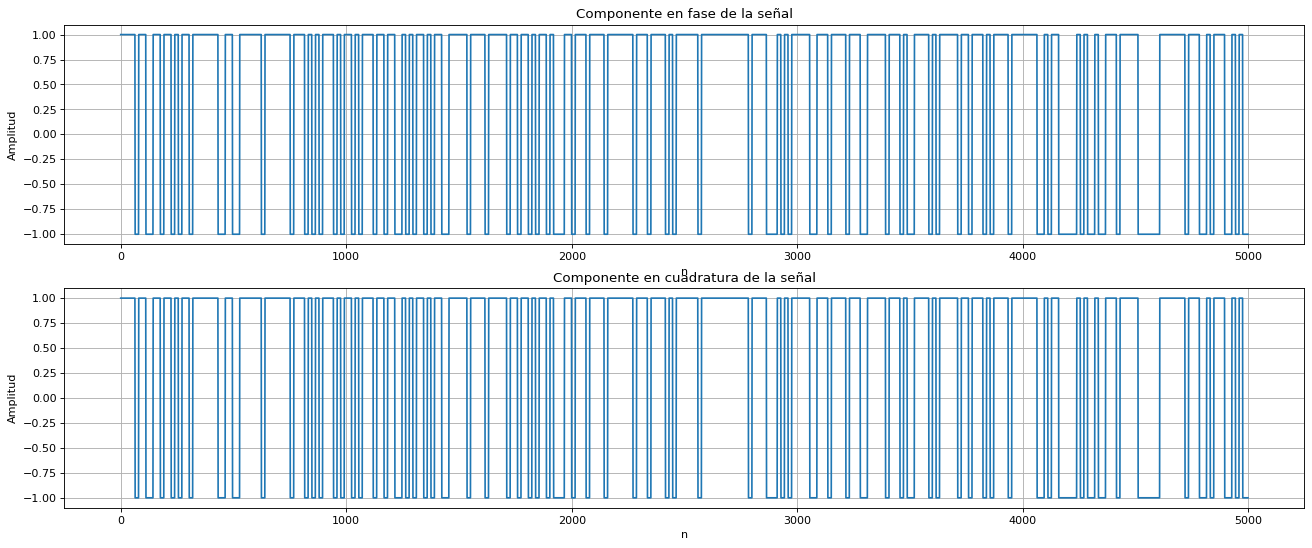

In [116]:
plotSignal(txSignal[0:5000])

### Grafica en frecuencia de la señal

Graficamos la densidad espectral:

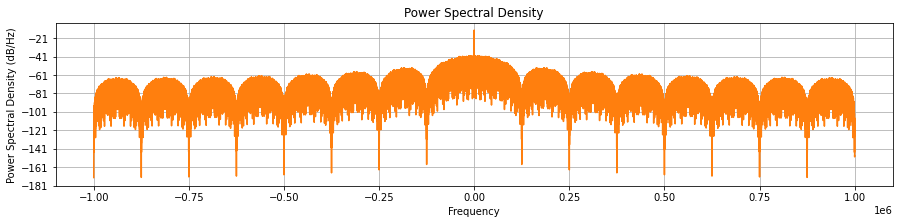

In [117]:
plotSpect(txSignal,samplingRate)

### Histograma de la señal

Graficamos el histograma de la señal para ver las componenentes de la señal.

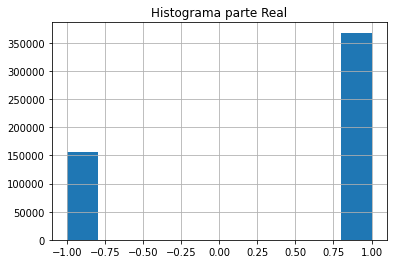

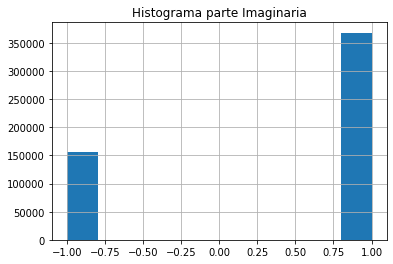

In [118]:
plt.hist(txSignal.real)
plt.grid()
plt.title("Histograma parte Real")
plt.show()

plt.hist(txSignal.imag)
plt.title("Histograma parte Imaginaria")
plt.grid()
plt.show()

### Transmisión

Limpiamos el buffer del transmisor, para que transmita con otra configuración: 

In [149]:
sdr.tx_destroy_buffer()
sdr.tx_cyclic_buffer = tx_cyclic_buffer

Configuramos el SDR de la siguiente manera:

In [150]:
TxAtten          = -78             # Attenuation applied to TX path, valid range is -89 to 0 dB [dB]
sdr.tx_hardwaregain_chan0 = TxAtten 

Transmitimos

In [151]:
#------------------------ Transmitter ------------------------------- 
sdr.tx(txSignal*(2**15-1)) # The PlutoSDR expects samples to be between -2^15-1 and +2^15-1, not -1 and +1 like some SDRs

### Recepción

Recibimos la señal nuevamente:

In [157]:
#Clear RX Buffer
for i in range(15):
    raw_data = sdr.rx()
    
#------------------------------- Receiver ------------------------------- 
rxSignal = sdr.rx()

### Normalización
Normailizamos la señal recibida para que tenga potencia unitaria.

In [158]:
desviacionReal = rxSignal.real.std()
print("Desviacion Real: ", desviacionReal)

desviacionImag = rxSignal.imag.std()
print("Desviacion Imaginaria: ",desviacionImag)

rxSignalRealN = rxSignal.real/desviacionReal
rxSignalImagN = rxSignal.imag/desviacionImag

Desviacion Real:  109.95808835431824
Desviacion Imaginaria:  83.97737553983158


### Grafica temporal de la señal recibida
Se gafica la señal recibida en el dominio del tiempo, vemos su parte real e imaginaria:

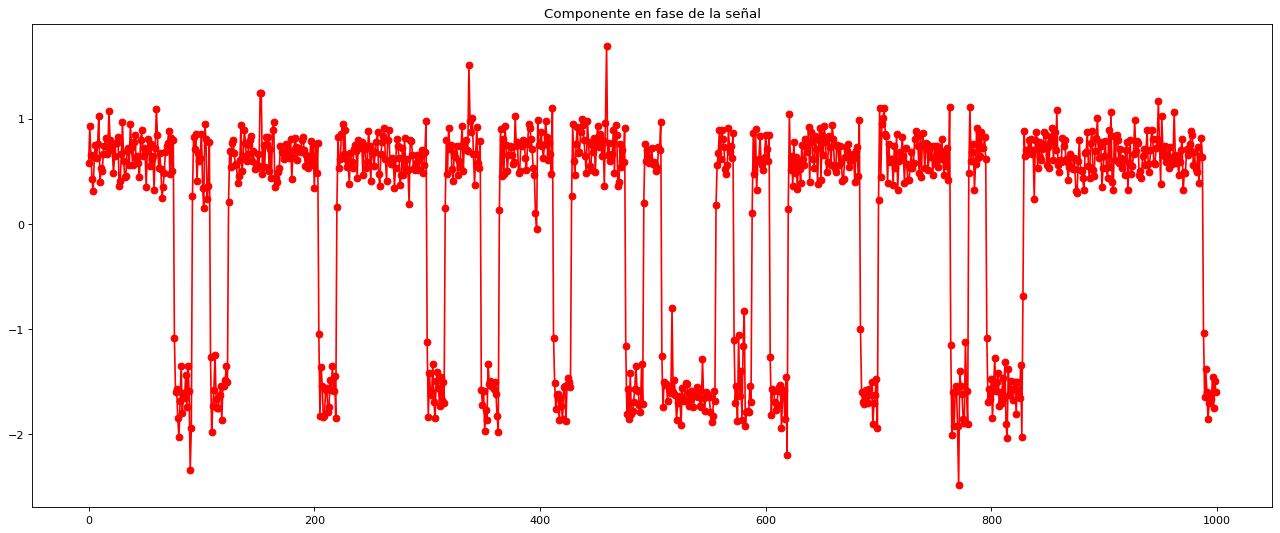

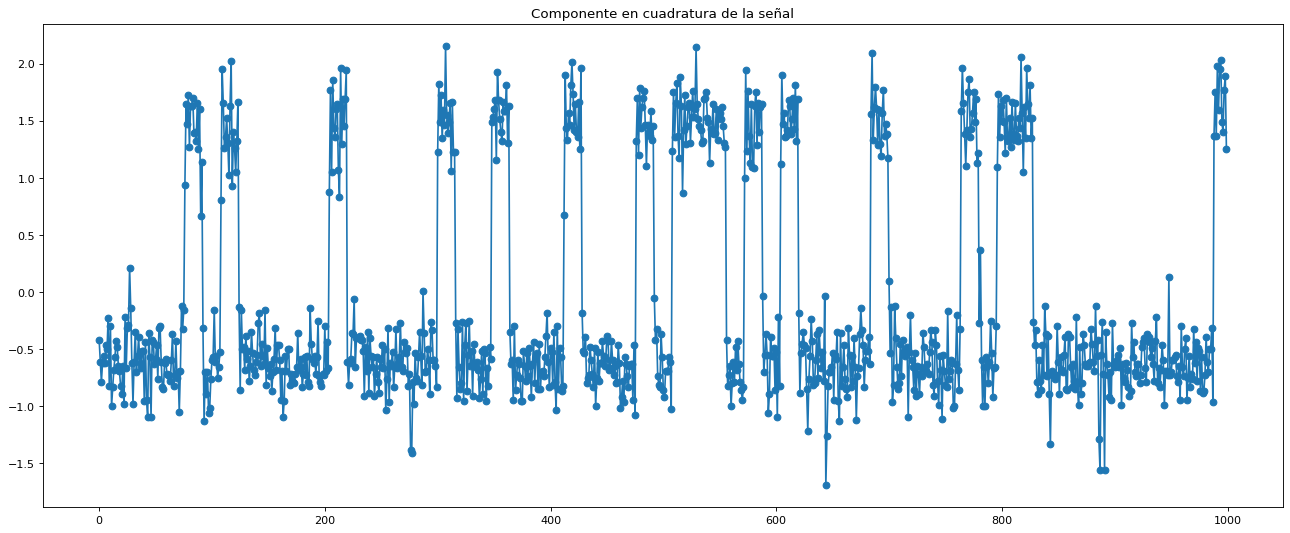

In [159]:
plt.figure(figsize=(20,8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(rxSignalRealN[1000:2000],marker="o", color='r')
plt.title("Componente en fase de la señal")
plt.show()

plt.figure(figsize=(20,8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(rxSignalImagN[1000:2000],marker="o")
plt.title("Componente en cuadratura de la señal")
plt.show()

### Grafica en frecuencia de la señal recibida
Se grafica la densidad espectral de potencia de la señal recibida

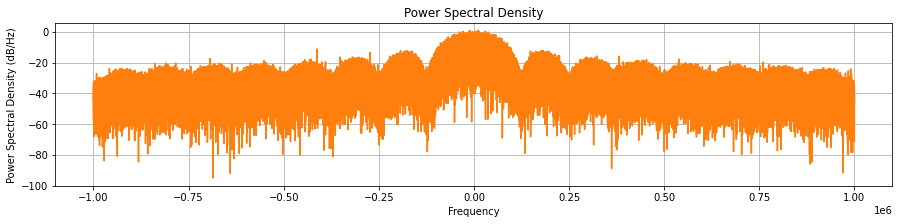

In [160]:
plotSpect(rxSignal,samplingRate)

### Histograma de la señal recibida
Realizamos el histograma de la señal normalizada, tanto de la parte real como imaginaria:

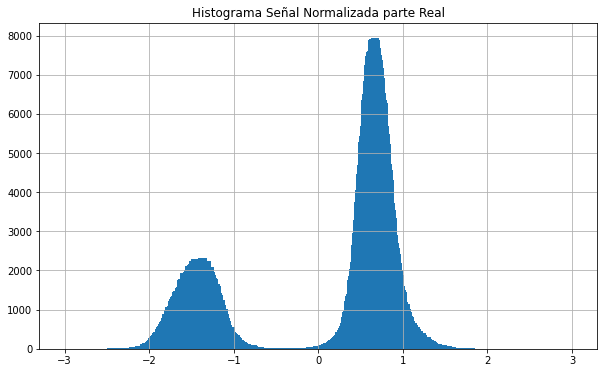

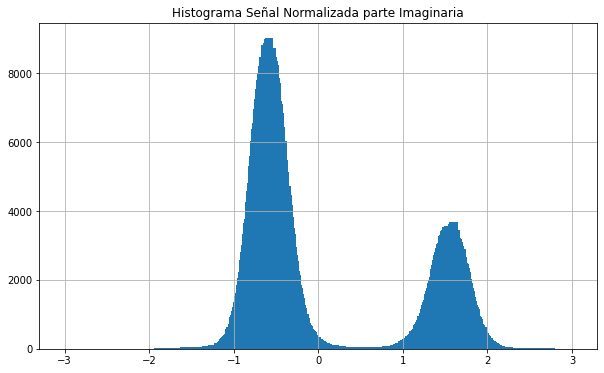

In [161]:
plt.figure(figsize=(10, 6))
plt.hist(rxSignalRealN, bins=10000, range=(-3, 3), width=0.1)
plt.title("Histograma Señal Normalizada parte Real")
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(rxSignalImagN, bins=10000, range=(-3, 3), width=0.1)
plt.title("Histograma Señal Normalizada parte Imaginaria")
plt.grid()
plt.show()

### Coclusiones al cambiar el nivel de decisión
Al cambiar el nivel de decisión podemos ver lo siguiente:
- En la gráfica temporal podemos verificar que se estan enviando más $1$ tanto en la parte real como imaginaria. 
- En el gráfico de la densidad espectral se puede visualizar la potencia y alguna ausencia de frecuencia igual que antes. Pero ahora las componentes de mayor frecuencia, presentan cierta disminución aunque siguen siendo infinitas.
- Y en el histogramas vemos como esta afectando el cambio en el nivel de decisión. Es más probable que tengamos un $1$ que un $-1$, esto es lo que se definio al enviar la señal. Por eso vemos en la parte real que es más probable tener $1$. En la parte imaginaria deberíamos ver lo mismo, pero se debe tener en cuenta que la señal es rotada por el medio, y puede llegar desfasada, por lo tanto podemos ver lo opuesto, como aparece en la parte imaginaria. 

## Cambio en el nivel de decisión y aumento de la potencia transmitida
Limpiamos nuevamente el buffer del transmisor, para que transmita con otra configuración:

In [162]:
sdr.tx_destroy_buffer()
sdr.tx_cyclic_buffer = tx_cyclic_buffer

Configuramos el SDR de la siguiente manera:

In [163]:
TxAtten          = -70              # Attenuation applied to TX path, valid range is -89 to 0 dB [dB]
sdr.tx_hardwaregain_chan0 = TxAtten  

### Transmisión
Se transmite:

In [164]:
#------------------------ Transmitter ------------------------------- 
sdr.tx(txSignal*(2**15-1)) # The PlutoSDR expects samples to be between -2^15-1 and +2^15-1, not -1 and +1 like some SDRs

### Recepción
Recibimos la señal nuevamente:

In [166]:
#Clear RX Buffer
for i in range(15):
    raw_data = sdr.rx()
    
#------------------------------- Receiver ------------------------------- 
rxSignal = sdr.rx()

### Normalización
Normailizamos la señal recibida para que tenga potencia unitaria.

In [167]:
desviacionReal = rxSignal.real.std()
print("Desviacion Real: ", desviacionReal)

desviacionImag = rxSignal.imag.std()
print("Desviacion Imaginaria: ",desviacionImag)

rxSignalRealN = rxSignal.real/desviacionReal
rxSignalImagN = rxSignal.imag/desviacionImag

Desviacion Real:  273.42393926342044
Desviacion Imaginaria:  200.53258066592605


### Grafica temporal de la señal recibida
Se gafica la señal recibida en el dominio del tiempo, vemos su parte real e imaginaria:

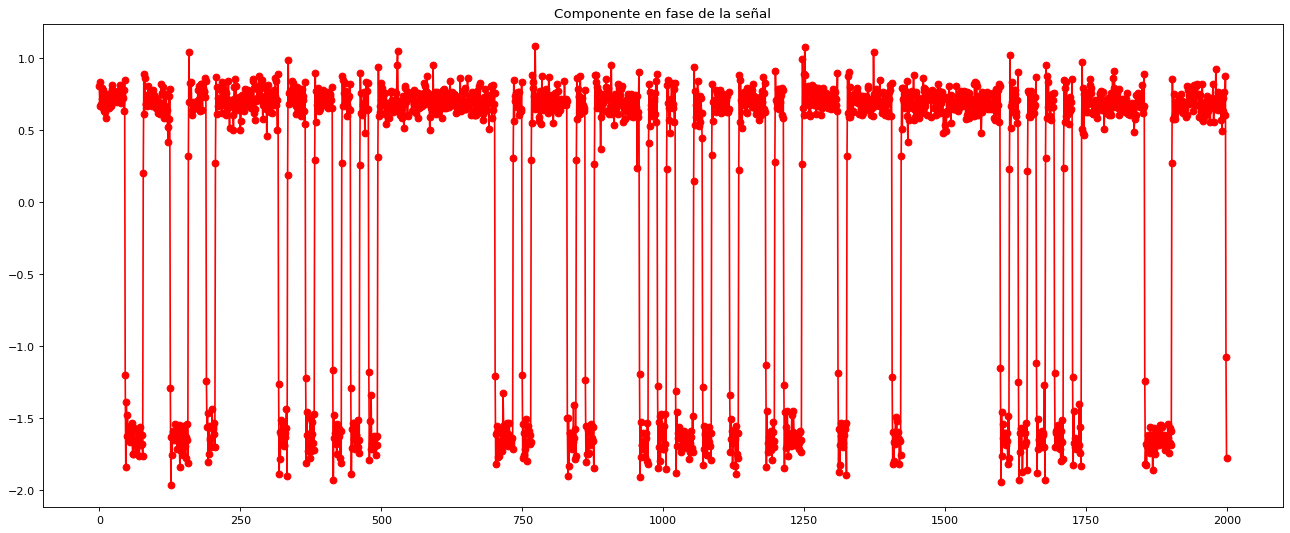

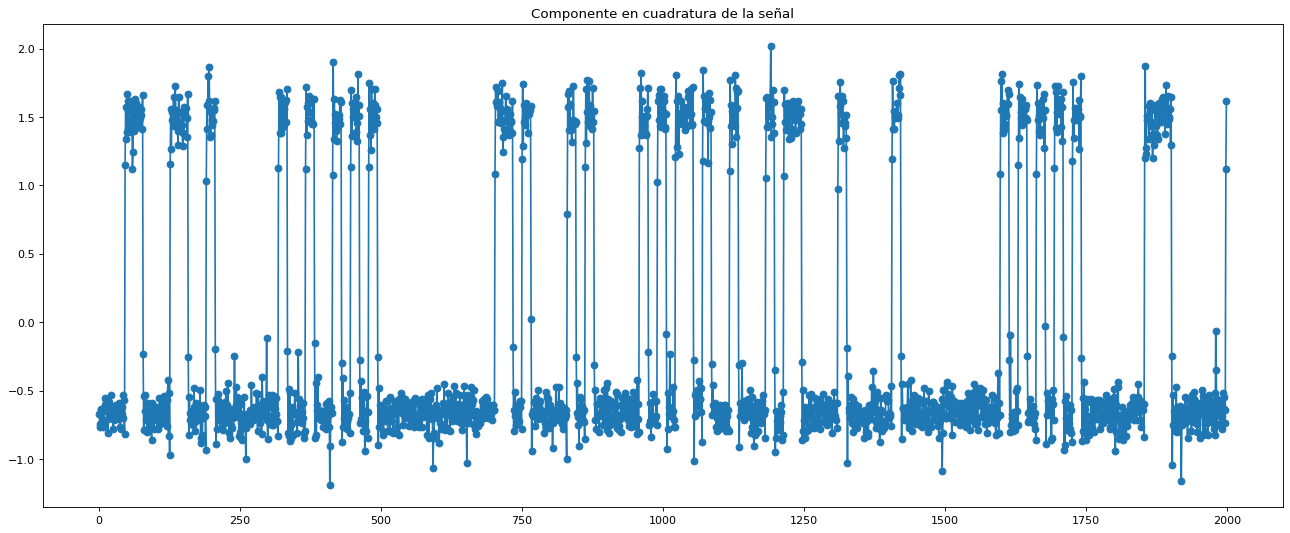

In [168]:
plt.figure(figsize=(20,8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(rxSignalRealN[0:2000],marker="o", color='r')
plt.title("Componente en fase de la señal")
plt.show()

plt.figure(figsize=(20,8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(rxSignalImagN[0:2000],marker="o")
plt.title("Componente en cuadratura de la señal")
plt.show()

### Grafica en frecuencia de la señal recibida
Se grafica la densidad espectral de potencia de la señal recibida

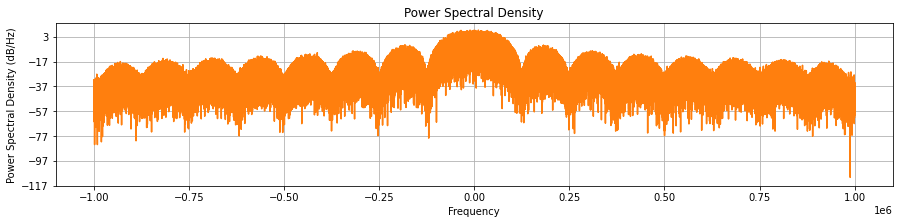

In [169]:
plotSpect(rxSignal,samplingRate)

### Histograma de la señal recibida
Realizamos el histograma de la señal normalizada, tanto de la parte real como imaginaria:

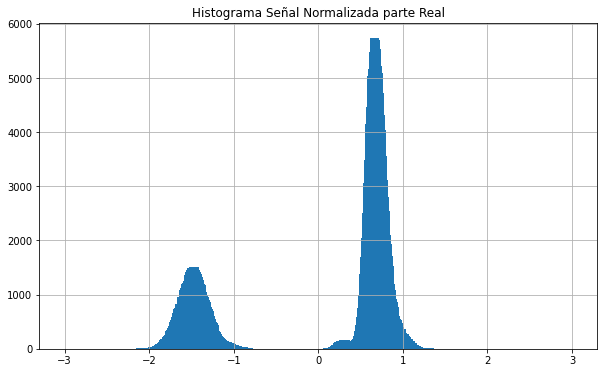

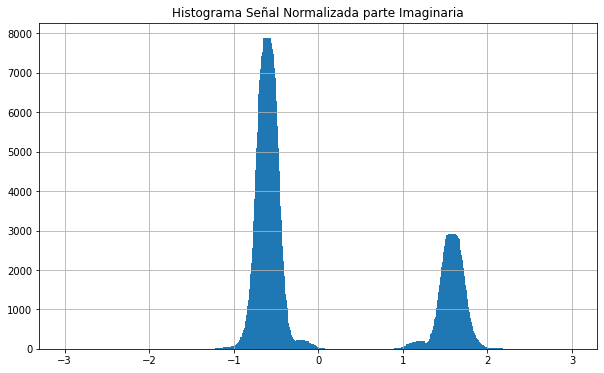

In [171]:
plt.figure(figsize=(10, 6))
plt.hist(rxSignalRealN, bins=10000, range=(-3, 3), width=0.1)
plt.title("Histograma Señal Normalizada parte Real")
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(rxSignalImagN, bins=10000, range=(-3, 3), width=0.1)
plt.title("Histograma Señal Normalizada parte Imaginaria")
plt.grid()
plt.show()

### Coclusiones al cambiar el nivel de decisión y la potencia
Al cambiar el nivel de decisión podemos ver lo siguiente:
- En la grafica temporal podemos ver nuevamente que se estan enviando más $1$ que $-1$, aunque el medio esta rotando la parte imaginaria y nos llega lo opuesto.
- En el gráfico de densidad espectral se aprecia justamente un aumento en la potencia, mayor definición de las formas, sigue presentando pérdidas de algunas frecuencias, y continua con un ancho de banda infinito. 
- En el histrograma notamos una disminución de la desviación estandar, es decir, las funciones densidad de probabilidad estan más definidas, y nuevamente se ve el fenómeno de que el ambiente rota la señal, ya que para el caso de la cuadratura debería tener más probabilidad el $1$ que el $-1$.

## Hipotensis cuaternarias
Se realiza el siguiente código para enviar una hipotesís $H \in \{ -1, -0.3333, +0.3333, 1 \}$ con iguales probabilidades:

In [11]:
# Parámetros
ref = 0.5                              # Probabilidad de ocurrencia - equiprobable
nSamples     = 2**18                   # Número de muestras -> tamaño del buffer
hipotesis = [-1, -0.3333, 0.3333, 1]   # Valores de la hipótesis

# Generar señales binarias
z = np.random.uniform(size=nSamples)   # Generador uniforme de números aleatorios
x = [1 if z[i] > ref else 0 for i in range(len(z))]  # Vector binario de acuerdo a la probabilidad de ocurrencia 

# Asignar valores según la hipótesis
txSignal = np.zeros(nSamples, dtype=complex)  # Inicializar señal binaria compleja

for i in range(0, nSamples, 2**4):
    index = np.random.choice(len(hipotesis))               # Elegir aleatoriamente un valor de la hipótesis
    index1 = np.random.choice(len(hipotesis))
    txSignal[i:i+2**4] = np.repeat(hipotesis[index] + 1j*hipotesis[index1], 2**4)  # Asignar el valor correspondiente

### Gráfica temporal de la señal recibida
En este punto se busca graficar la parte real e imaginaria de la señal que se va a transmitir, para ello se define la siguiente función:

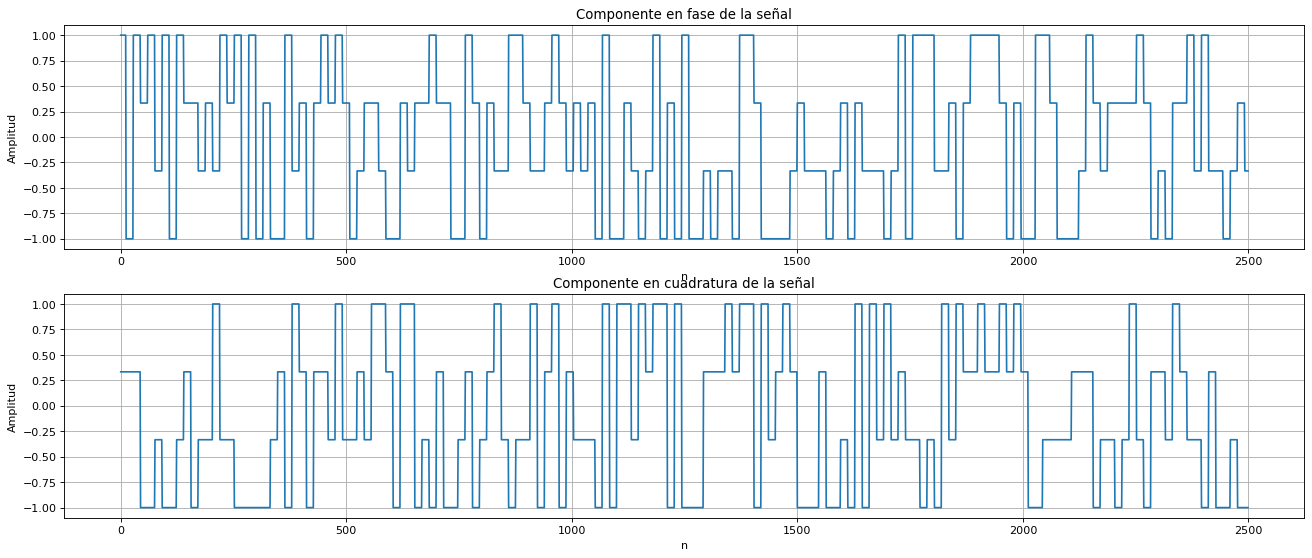

In [15]:
plotSignal(txSignal[2500:5000])

### Grafica en frecuencia de la señal
Graficamos la densidad espectral:

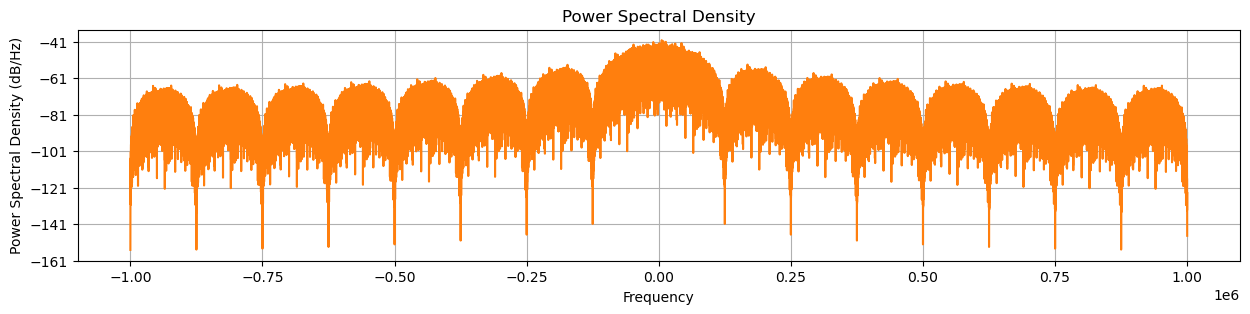

In [16]:
plotSpect(txSignal,samplingRate)

### Histograma de la señal
Graficamos el histograma de la señal para ver las componenentes de la señal.

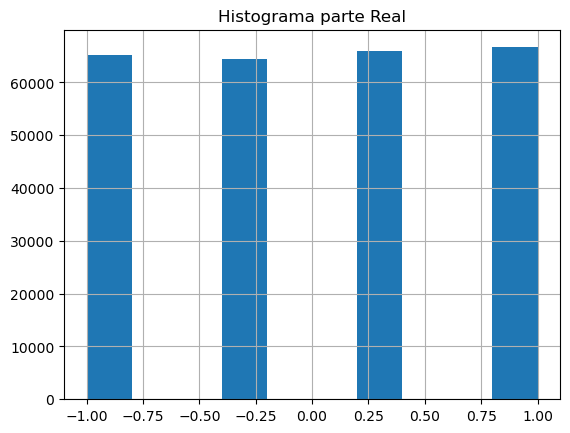

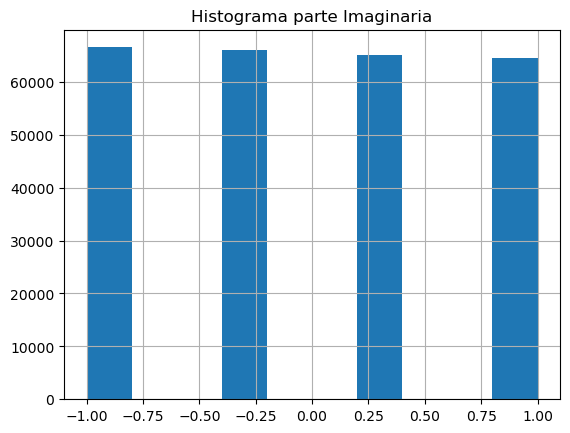

In [17]:
plt.hist(txSignal.real)
plt.grid()
plt.title("Histograma parte Real")
plt.show()

plt.hist(txSignal.imag)
plt.title("Histograma parte Imaginaria")
plt.grid()
plt.show()

### Transmisión
Limpiamos el buffer del transmisor, para que transmita con otra configuración: 

In [33]:
sdr.tx_destroy_buffer()
sdr.tx_cyclic_buffer = tx_cyclic_buffer

Configuramos el SDR de la siguiente manera:

In [34]:
TxAtten          = -78            # Attenuation applied to TX path, valid range is -89 to 0 dB [dB]
sdr.tx_hardwaregain_chan0 = TxAtten 

Transmitimos:

In [35]:
#----------------- Transmitter ------------------------------- 
sdr.tx(txSignal*(2**15-1)) # The PlutoSDR expects samples to be between -2^15-1 and +2^15-1, not -1 and +1 like some SDRs

### Recepción
Recibimos la señal nuevamente:

In [36]:
#Clear RX Buffer
for i in range(15):
    raw_data = sdr.rx()
    
#------------------------------- Receiver ------------------------------- 
rxSignal = sdr.rx()

### Normalización
Normailizamos la señal recibida para que tenga potencia unitaria.

In [37]:
desviacionReal = rxSignal.real.std()
print("Desviacion Real: ", desviacionReal)

desviacionImag = rxSignal.imag.std()
print("Desviacion Imaginaria: ",desviacionImag)

rxSignalRealN = rxSignal.real/desviacionReal
rxSignalImagN = rxSignal.imag/desviacionImag

Desviacion Real:  82.0956465519081
Desviacion Imaginaria:  82.06936831119799


### Grafica temporal de la señal recibida
Se gafica la señal recibida en el dominio del tiempo, vemos su parte real e imaginaria:

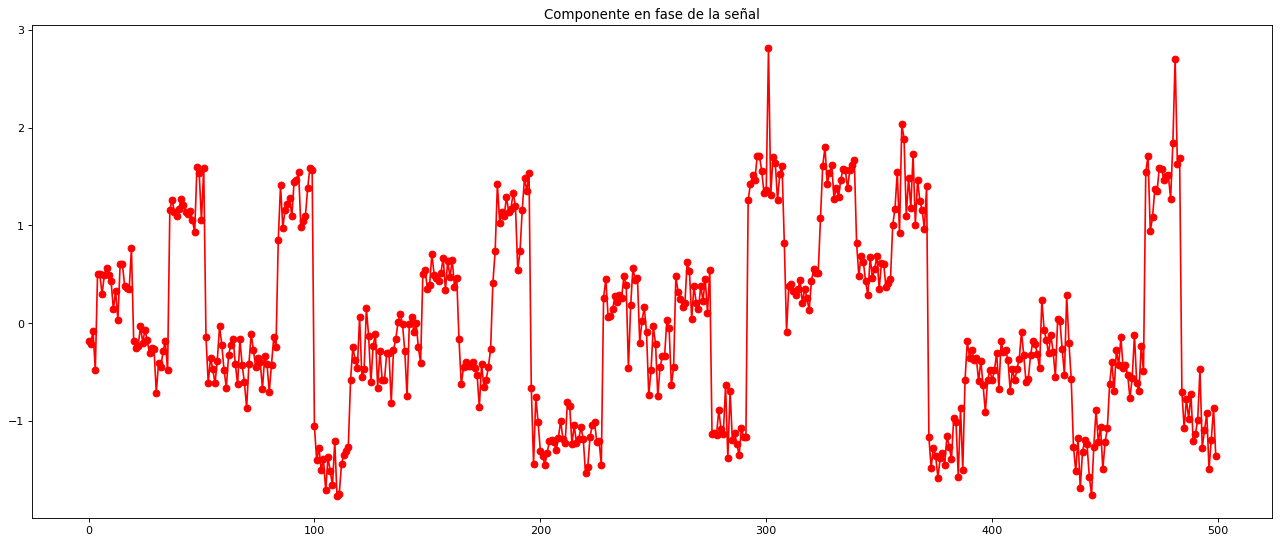

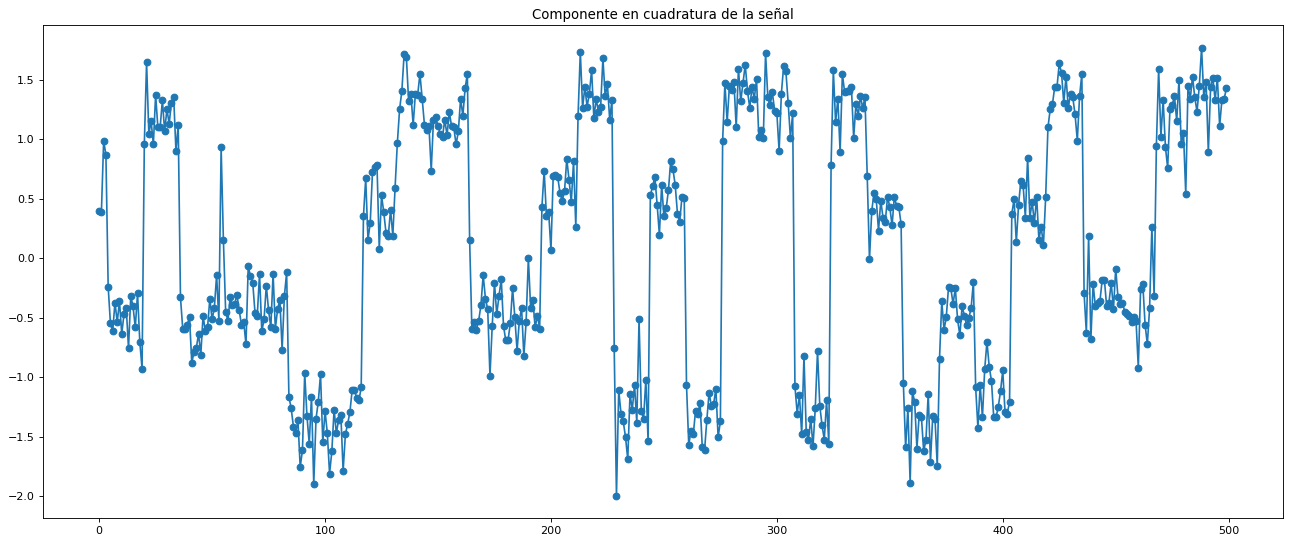

In [25]:
plt.figure(figsize=(20,8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(rxSignalRealN[2000:2500],marker="o", color='r')
plt.title("Componente en fase de la señal")
plt.show()

plt.figure(figsize=(20,8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(rxSignalImagN[2000:2500],marker="o")
plt.title("Componente en cuadratura de la señal")
plt.show()

### Grafica en frecuencia de la señal recibida
Se grafica la densidad espectral de potencia de la señal recibida

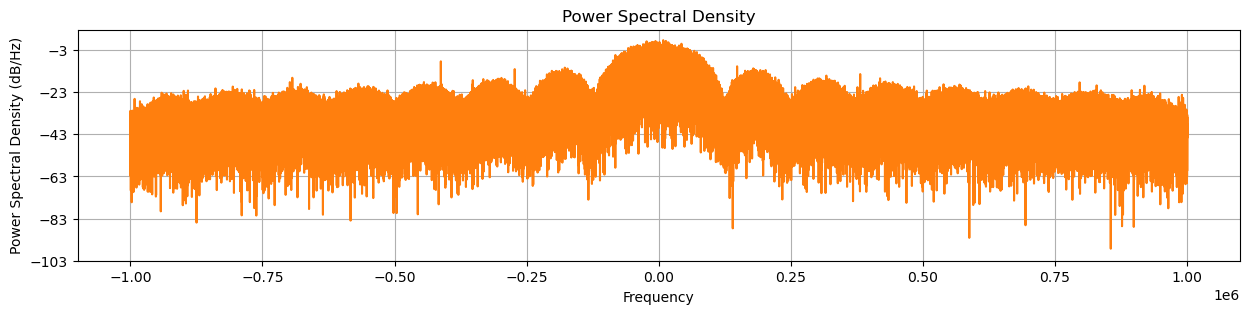

In [26]:
plotSpect(rxSignal,samplingRate)

### Histograma de la señal recibida
Realizamos el histograma de la señal normalizada, tanto de la parte real como imaginaria:

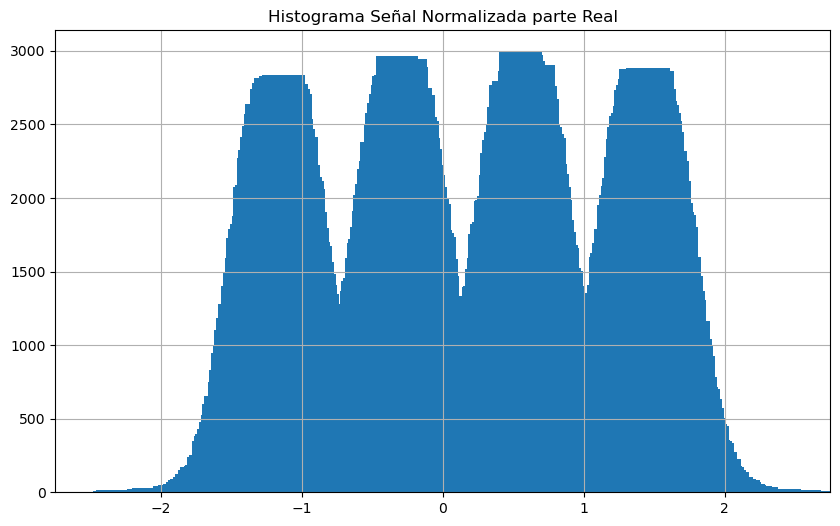

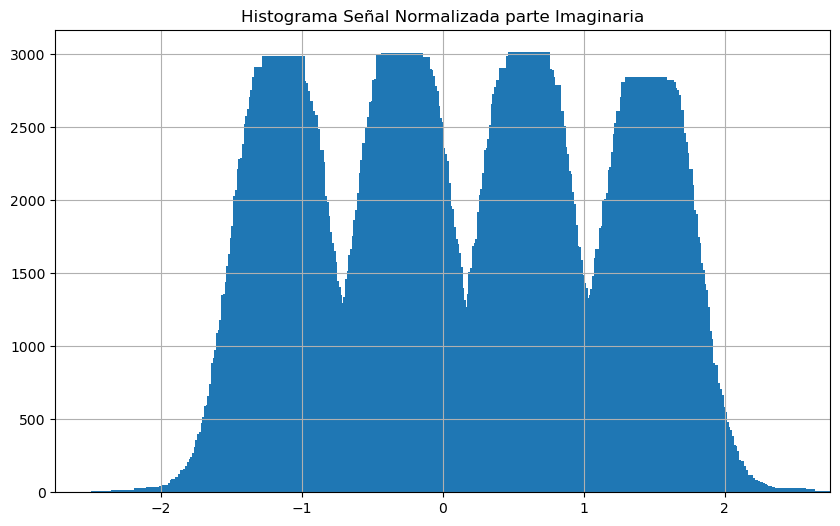

In [38]:
plt.figure(figsize=(10, 6))
plt.hist(rxSignalRealN,bins=10000,width=0.3,range=(-2.5,2.5))
plt.title("Histograma Señal Normalizada parte Real")
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(rxSignalImagN,bins=10000,width=0.3,range=(-2.5,2.5))
plt.title("Histograma Señal Normalizada parte Imaginaria")
plt.grid()
plt.show()

### Coclusiones al transmitir cuatro hipotesís
Al aumentar el número de hipotesís podemos ver lo siguiente:
- En la grafica temporal podemos verificar que nuestro generador esta enviando cuatro valores diferentes: $\{-1,-0.3,0.3,1\}$ aunque es difícil distinguirlos por que hay cierto ruido.
- En el grafico de densidad espectral al igual que en los ítem anteriores se continua viendo una gran cantidad de armónicos, un gran ancho de banda.
- Y en el histograma, podemos ver los valores centrados en $\{-1,-0.3,0.3,1\}$ tanto en la parte real como imaginaria. Podemos apreciar también que en este caso es más complicado aplicar una regla de decisión con poca probabilidad de error, ya que las funciones de distribución de probabilidad se encuentran superpuestas. También cabe destacar que fue necesrio aumentar el número de muestras ya que aumento el número de hipótesis. Y se normalizo ya que estamos dividiendo por una constante y es de esperar el mismo resultado.

## Transmisión con máxima atenuación

Dado que no es posible apagar la etapa transmisora del SDR, es recomendable antes de finalizar la experiencia, dejar configurado el transmisor con la máxima atenuación posible, asegurarse que las frecuencias de transmisión y recepción no coinciden y cargar al Buffer transmisor con ceros. Esto permitirá minimizar cualquier posible interferencia por parte del SDR.

In [14]:
# Since it is not possible to turn off Tx, it is configured to transmit at low power and on a different frequency than Rx.
sdr.tx_destroy_buffer()
sdr.tx_hardwaregain_chan0 = -89 
sdr.tx_lo                 = int(2400e6)
sdr.rx_lo                 = int(950e6)
sdr.tx(np.zeros(2048))

# Destroy radio object
del(sdr)